# CZĘŚĆ 2

## OPIS ZESTAWU DANYCH
Dane składają się z informacji o przylotach i odlotach wszystkich lotów komercyjnych w USA od października 1987 do kwietnia 2008 – przede wszystkim o ich opóźnieniach. \
Zbiór danych jest bardzo duży (120mln rekordów, 12GB danych) – na potrzeby projektu wykorzystamy jedynie dane z roku 2007 co ograniczy rozmiar przetwarzanych danych.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from Tools.scripts.dutree import display
import zipfile

zf = zipfile.ZipFile("./data_mow.zip")
namelist = zf.namelist()[1:]
dfs = [pd.read_csv(zf.open(f)) for f in namelist]
data = pd.concat(dfs, ignore_index=True)
data = data[data["Year"] == 2007]
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.head())

In [3]:
data.drop(
    ['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode', 'FlightNum', 'TaxiIn', 'TaxiOut', 'DepTime',
     'ArrTime', 'ActualElapsedTime', 'AirTime', 'DepDelay', 'ArrDelay'], inplace=True, axis=1)

In [4]:
for column in ['CRSDepTime', 'CRSArrTime']:
    data[column] = data[column] // 100 + (data[column] % 100) / 60

In [5]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.describe())

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7452221.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00
mean,2007.00,6.51,15.73,3.93,13.48,15.15,127.25,719.81,0.02,0.00,3.87,0.77,3.78,0.02,5.10
std,0.00,3.43,8.78,1.99,4.66,4.82,70.36,562.31,0.15,0.05,20.84,9.62,16.18,1.08,21.28
min,2007.00,1.00,1.00,1.00,0.00,0.00,-1240.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2007.00,4.00,8.00,2.00,9.50,11.25,77.00,319.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2007.00,7.00,16.00,4.00,13.37,15.33,110.00,569.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2007.00,9.00,23.00,6.00,17.33,19.10,156.00,946.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2007.00,12.00,31.00,7.00,23.98,24.00,1430.00,4962.00,1.00,1.00,2580.00,1429.00,1386.00,382.00,1031.00


In [6]:
data["Year"] = data["Year"].astype("int")

## PROBLEMY Z DANYMI - DANE BRAKUJĄCE, NIEPRAWIDŁOWE, ODSTAJĄCE

### SPRAWDZENIE POPRAWNOŚCI TYPÓW DANYCH

In [7]:
# data = pd.read_parquet("./data_mow_2007.parquet")

In [8]:
data.dtypes

Year                   int32
Month                  int64
DayofMonth             int64
DayOfWeek              int64
CRSDepTime           float64
CRSArrTime           float64
CRSElapsedTime       float64
Distance               int64
Cancelled              int64
Diverted               int64
CarrierDelay           int64
WeatherDelay           int64
NASDelay               int64
SecurityDelay          int64
LateAircraftDelay      int64
dtype: object

Jak widać wyżej - wszystkie dane występują w poprawnym formacie.

### NAPRAWA WIERSZY Z PUSTYMI DANYMI

In [9]:
data["CRSElapsedTime"] = data["CRSElapsedTime"].map(lambda v: np.NAN if v < 0 else v)

In [10]:
data_with_nulls = data.copy()
np.random.seed(42)
data_with_nulls["Distance"] = data_with_nulls["Distance"].mask(np.random.random(data_with_nulls.shape[0]) < 0.1)
data_with_nulls["WeatherDelay"] = data_with_nulls["WeatherDelay"].mask(np.random.random(data_with_nulls.shape[0]) < 0.1)

In [11]:
np.sum(data_with_nulls.isna())

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
CRSDepTime                0
CRSArrTime                0
CRSElapsedTime          996
Distance             746296
Cancelled                 0
Diverted                  0
CarrierDelay              0
WeatherDelay         743989
NASDelay                  0
SecurityDelay             0
LateAircraftDelay         0
dtype: int64

##### PROSTA METODA - WYPEŁNIANIE 0

In [12]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["CRSElapsedTime"].describe())

count   7452219.00
mean        127.25
std          70.36
min           1.00
25%          77.00
50%         110.00
75%         156.00
max        1430.00
Name: CRSElapsedTime, dtype: float64

In [13]:
data_with_nulls["CRSElapsedTime"].fillna(0, inplace=True)

In [14]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["CRSElapsedTime"].describe())

count   7453215.00
mean        127.23
std          70.37
min           0.00
25%          77.00
50%         110.00
75%         156.00
max        1430.00
Name: CRSElapsedTime, dtype: float64

##### ROZKŁAD ZMIENNEJ

In [15]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data["Distance"].describe())

count   7453215.00
mean        719.81
std         562.31
min          11.00
25%         319.00
50%         569.00
75%         946.00
max        4962.00
Name: Distance, dtype: float64

In [16]:
from scipy.stats import gaussian_kde

# estimate density
density = gaussian_kde(data["Distance"])

# use density to imput missing values
data_with_nulls["Distance"].fillna(density.resample(1)[0][0], inplace=True)

In [17]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["Distance"].describe())

count   7453215.00
mean        893.01
std         744.25
min          11.00
25%         337.00
50%         622.00
75%        1127.00
max        4962.00
Name: Distance, dtype: float64

##### Regresja

In [18]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["WeatherDelay"].describe())

count   6709226.00
mean          0.77
std           9.57
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        1429.00
Name: WeatherDelay, dtype: float64

In [19]:
# build regression model for WeatherDelay
from sklearn.linear_model import LinearRegression

columns = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
           'CRSElapsedTime', 'Distance', 'Cancelled', 'Diverted', 'CarrierDelay',
           'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

model = LinearRegression()
model = model.fit(data_with_nulls.dropna()[columns], data_with_nulls["WeatherDelay"].dropna())

In [20]:
# impute missing values using regression model
# for each row with missing value in WeatherDelay
data_with_nulls.loc[data_with_nulls["WeatherDelay"].isna(), "WeatherDelay"] = model.predict(
    data_with_nulls[data_with_nulls["WeatherDelay"].isna()][columns])

In [21]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["WeatherDelay"].describe())

count   7453215.00
mean          0.77
std           9.08
min          -6.00
25%           0.00
50%           0.00
75%           0.00
max        1429.00
Name: WeatherDelay, dtype: float64

In [22]:
# if value less than 0, set to 0
data_with_nulls["WeatherDelay"] = data_with_nulls["WeatherDelay"].map(lambda v: 0 if v < 0 else v)

In [23]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_with_nulls["WeatherDelay"].describe())

count   7453215.00
mean          0.77
std           9.08
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        1429.00
Name: WeatherDelay, dtype: float64

#### SKALOWANIE DANYCH

In [24]:
data_to_scale = data_with_nulls.copy()

data_minmax = data_to_scale.copy()
columns = [column for column in data_minmax.columns if column != 'Cancelled']
for column in columns:
    data_minmax[column] = (data_minmax[column] - data_minmax[column].min()) / (
                data_minmax[column].max() - data_minmax[column].min())

In [25]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data_minmax.describe())

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,0.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00
mean,NaN,0.50,0.49,0.49,0.56,0.63,0.09,0.18,0.02,0.00,0.00,0.00,0.00,0.00,0.00
std,NaN,0.31,0.29,0.33,0.19,0.20,0.05,0.15,0.15,0.05,0.01,0.01,0.01,0.00,0.02
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,0.27,0.23,0.17,0.40,0.47,0.05,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,0.55,0.50,0.50,0.56,0.64,0.08,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,0.73,0.73,0.83,0.72,0.80,0.11,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [26]:
data_standard = data_to_scale.copy()
columns = [column for column in data_minmax.columns if column != 'Cancelled']
for column in columns:
    data_standard[column] = (data_standard[column] - data_standard[column].mean()) / data_standard[column].std()

In [27]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data_standard.describe())

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,0.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00,7453215.00
mean,NaN,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.02,0.00,-0.00,0.00,-0.00,-0.00,0.00
std,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.15,1.00,1.00,1.00,1.00,1.00,1.00
min,NaN,-1.61,-1.68,-1.47,-2.89,-3.14,-1.81,-1.19,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
25%,NaN,-0.73,-0.88,-0.97,-0.85,-0.81,-0.71,-0.75,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
50%,NaN,0.14,0.03,0.03,-0.02,0.04,-0.24,-0.36,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
75%,NaN,0.73,0.83,1.04,0.83,0.82,0.41,0.31,0.00,-0.05,-0.19,-0.08,-0.23,-0.02,-0.24
max,NaN,1.60,1.74,1.54,2.25,1.84,18.51,5.47,1.00,20.81,123.60,157.32,85.44,352.05,48.22


In [28]:
# data_standard.to_parquet("./data_mow_2007_standard.parquet")

In [29]:
# data_minmax.to_parquet("./data_mow_2007_minmax.parquet")

### PODZIAŁ DANYCH

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data_standard = pd.read_parquet("./data_mow_2007_standard.parquet")
data_minmax = pd.read_parquet("./data_mow_2007_minmax.parquet")

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

columns =['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'Distance', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled']

def train_test_split(X, Y, test_size):
    train_pct_index = int((1 - test_size) * len(X))
    train_pct_indexY = int((1 - 0.20) * len(Y))

    trainDF_x = pd.DataFrame(X[:train_pct_index], columns = columns)
    trainDF_y = pd.DataFrame(Y[:train_pct_indexY], columns = columns)
    trainDF = trainDF_x.append(trainDF_y)
    trainDF = trainDF.sample(frac=1, random_state=42)
    trainDF = trainDF.to_numpy()

    testDF_x = pd.DataFrame(X[train_pct_index:], columns = columns)
    testDF_y = pd.DataFrame(Y[train_pct_indexY:], columns = columns)
    testDF = testDF_x.append(testDF_y)
    testDF = testDF.sample(frac=1, random_state=42)
    testDF = testDF.to_numpy()

    return trainDF[:, :-1], testDF[:, :-1], trainDF[:, -1:], testDF[:, -1:]



def splitOfData(dataInput, testSize):
    cancelled = dataInput['Cancelled']==1
    dataCancelled = dataInput[cancelled]
    dataNotCancelled = dataInput[~cancelled]
    return train_test_split(dataNotCancelled, dataCancelled, test_size=testSize)

data_for_training_standard = data_standard[['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'Distance', 'Diverted', 'CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled']]
data_for_training_minmax = data_minmax[['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime','CRSElapsedTime', 'Distance', 'Diverted', 'CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled']]

x_train_standard, x_test_standard, y_train_standard, y_test_standard = splitOfData(data_for_training_standard, 0.2)
x_train_minmax, x_test_minmax, y_train_minmax, y_test_minmax = splitOfData(data_for_training_minmax, 0.2)

data_sets = [("standarized", x_train_standard, y_train_standard, x_test_standard, y_test_standard), ("min-max", x_train_minmax, y_train_minmax, x_test_minmax, y_test_minmax)]
print("")
print("x_train_standard: ", x_train_standard.shape)
print("x_test_standard: ", x_test_standard.shape)
print("y_train_standard: ", y_train_standard.shape)
print("y_test_standard: ", y_test_standard.shape)

print("")
print("x_train_minmax.shape: ", x_train_minmax.shape)
print("x_test_minmax.shape: ", x_test_minmax.shape)
print("y_train_minmax.shape: ", y_train_minmax.shape)
print("y_test_minmax.shape: ", y_test_minmax.shape)



x_train_standard:  (5962571, 13)
x_test_standard:  (1490644, 13)
y_train_standard:  (5962571, 1)
y_test_standard:  (1490644, 1)

x_train_minmax.shape:  (5962571, 13)
x_test_minmax.shape:  (1490644, 13)
y_train_minmax.shape:  (5962571, 1)
y_test_minmax.shape:  (1490644, 1)


### MIARY SKUTECZNOŚCI

In [4]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def effectiveness_measures_classifier(y_test, predictions):
    acc=accuracy_score(y_test, predictions)
    print("Prediction Accuracy: ", acc)

    f1=f1_score(y_test, predictions)
    print("F1: ", f1)

    precision=precision_score(y_test, predictions)
    print("Precision: ", precision)

    recall=recall_score(y_test, predictions)
    print("Recall: ", recall)

    return acc, f1, precision, recall


### DECISION TREE CLASSIFIER

Decision Tree Classifier (standarized data):


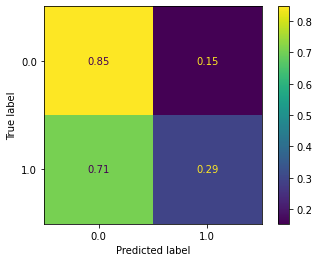

Prediction Accuracy:  0.8353979890570787
F1:  0.07156884632412204
Precision:  0.04074062905219988
Recall:  0.2941524105754277

Decision Tree Classifier (min-max data):


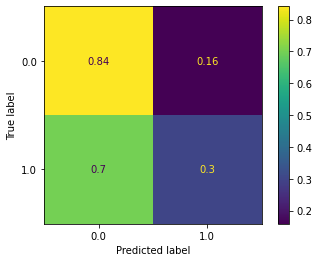

Prediction Accuracy:  0.8298507222381736
F1:  0.07082933405625609
Precision:  0.040142681549398714
Recall:  0.30068429237947125



In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

eff_dtc = []

for name, x_train, y_train, x_test, y_test in data_sets:
    dtc = DecisionTreeClassifier(max_depth=10, class_weight="balanced").fit(x_train, y_train)
    pred = dtc.predict(x_test)
    print(f"Decision Tree Classifier ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_dtc.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model drzewa decyzyjnego dość słabo poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane tylko około 30% próbek dodatnich. Trochę lepsze wyniki zostały osiągnięte dla danych przeskalowanych metodą standaryzacji - poprawnie sklasyfikowane zostało o 1% więcej próbek dodatnich. Jeśli chodzi o klasę negatywną tutaj wyniki są dobre - poprawnie sklasyfikowano około 85% próbek.

### GAUSSIAN NB

Gaussian Naive Bayes (standarized data):


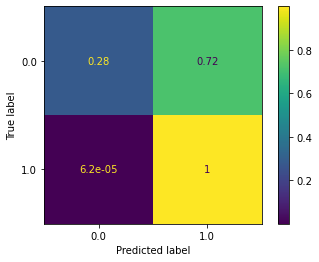

Prediction Accuracy:  0.2995805839623679
F1:  0.05800940478467518
Precision:  0.02987116041114194
Recall:  0.9999377916018662

Gaussian Naive Bayes (min-max data):


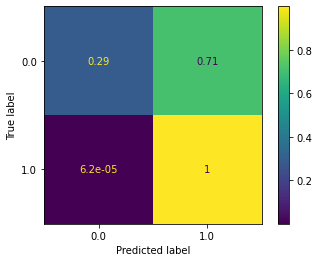

Prediction Accuracy:  0.30754023093374405
F1:  0.05863710856383043
Precision:  0.03020415142663599
Recall:  0.9999377916018662



In [6]:
from sklearn.naive_bayes import GaussianNB
from numpy import ravel

eff_gnb = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    gnb = GaussianNB().fit(x_train, y_train_ravel)
    pred = gnb.predict(x_test)
    print(f"Gaussian Naive Bayes ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_gnb.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model naiwny Bayessa przeuczył się względem próbek z klasy pozytywnej - poprawnie zaklasyfikowano prawie 100% próbek. Jednak spowodowało to bardzo niską skuteczność wykrywania próbek ujemnych - czyli lotów, które nie zostały odwołane - jedynie niecałe 30% z nich zostało przewidziane poprawnie. Trochę lepiej radził sobie model z danymi skalowanymi min-max, uzyskał on wynik o 1% lepszy niż model ze standardowym skalowaniem.

### LOGISTIC REGRESSION

Logistic Regression (standarized data):


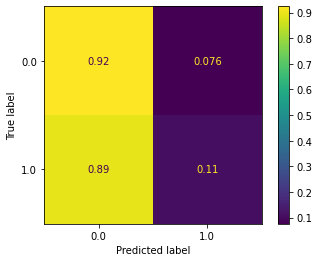

Prediction Accuracy:  0.906592050147453
F1:  0.046732938985650126
Precision:  0.029961198799094053
Recall:  0.10615863141524105

Logistic Regression (min-max data):


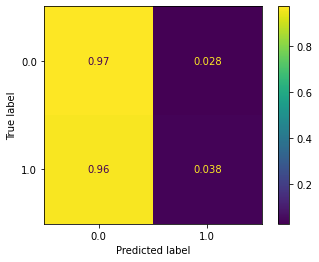

Prediction Accuracy:  0.9516618320672139
F1:  0.03262401825870981
Precision:  0.028699657493799456
Recall:  0.037791601866251946



In [7]:
from sklearn.linear_model import LogisticRegression
from numpy import ravel

eff_lr = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    lr = LogisticRegression(random_state=42, max_iter=5000, class_weight="balanced", n_jobs=-1).fit(x_train, y_train_ravel)
    pred = lr.predict(x_test)
    print(f"Logistic Regression ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_lr.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model regresji logistycznej przeuczył się względem próbek z klasy negatywnej - poprawnie zaklasyfikowano ponad 90% próbek. Jednak spowodowało to bardzo niską skuteczność wykrywania próbek dodatnich - czyli lotów, które zostały odwołane - jedynie od 4 do 11 % z nich zostało przewidziane poprawnie. W tym przypadku rodzaj skalowania danych miał duży wpływ na jakość klasyfikacji - dane przeskalowane metodą standardową (czyli w przeciwieństwie do poprzednich dwóch modeli) zaklasyfikował o 8% więcej próbek pozytywnych od modelu ze skalowaniem metodą min-max, przy niższej o około 5% skuteczności przewidywania klasy negatywnej.

### RANDOM FOREST

Random Forest Classifier (standarized data):


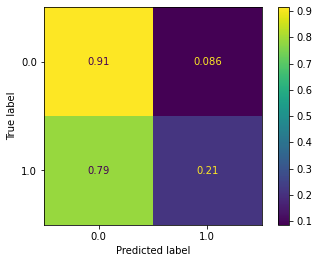

Prediction Accuracy:  0.8991986014098604
F1:  0.08331147240948052
Precision:  0.051819527188555384
Recall:  0.21237947122861586

Random Forest Classifier (min-max data):


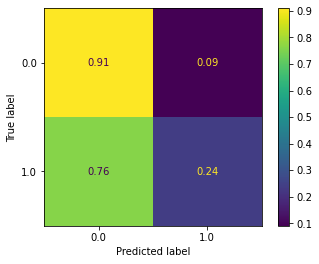

Prediction Accuracy:  0.8950426795398498
F1:  0.0893884012758131
Precision:  0.05498274405350059
Recall:  0.23884914463452567



In [8]:
from sklearn.ensemble import RandomForestClassifier
from numpy import ravel

eff_rfc = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    rfc = RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced", n_estimators=12, n_jobs=-1).fit(x_train, y_train_ravel)
    pred = rfc.predict(x_test)
    print(f"Random Forest Classifier ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_rfc.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model lasu losowego bardzo dobrze poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane między 21 a 24% próbek dodatnich oraz 91% próbek ujemnych. Trochę lepsze wyniki zostały osiągnięte dla danych przeskalowanych metodą min-max - poprawnie sklasyfikowane zostało o 3% więcej próbek dodatnich. Mimo niższej skuteczności przewidywania klasy dodatniej, na podstawie wyniku F1 score można stwierdzić, że model lasu losowego ze skalowaniem min-max najlepiej ze wszystkich wcześniej testowanych modeli poradził sobie z klasyfikacją danych dotyczących odwołanych lotów.

### XGBOOST CLASSIFIER

XGBoost Classifier (standarized data):


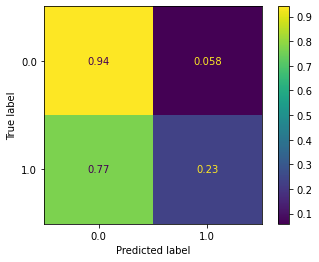

Prediction Accuracy:  0.926295614512922
F1:  0.119436719056817
Precision:  0.0804478562713914
Recall:  0.23175738724727837

XGBoost Classifier (min-max data):


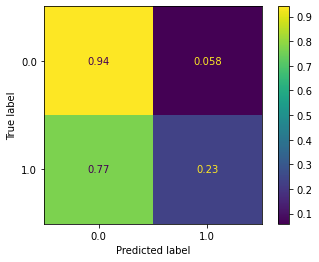

Prediction Accuracy:  0.926295614512922
F1:  0.119436719056817
Precision:  0.0804478562713914
Recall:  0.23175738724727837



In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

eff_xgb = []

for name, x_train, y_train, x_test, y_test in data_sets:
    xgb = XGBClassifier(tree_method='gpu_hist', scale_pos_weight=49).fit(x_train, y_train)
    pred = xgb.predict(x_test)
    print(f"XGBoost Classifier ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test, pred, normalize='true')
    plt.show()
    eff_xgb.append(effectiveness_measures_classifier(y_test, pred))
    print("")


Na powyższych macierzch pomyłek można zauważyć, że model XGBoost bardzo dobrze poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane 23% próbek dodatnich oraz 94% próbek ujemnych. Mimo niższej skuteczności przewidywania klasy dodatniej, na podstawie wyniku F1 score można stwierdzić, że model XGBoost poradził sobie lepiej niż model lasu losowego.

#### ENSEMBLE CLASSIFIER - ADABOOST

AdaBoost (standarized data):


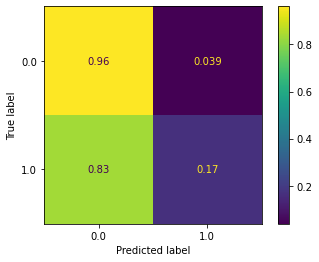

Prediction Accuracy:  0.9442093484426866
F1:  0.11329566051817892
Precision:  0.08619402985074627
Recall:  0.1652566096423017

AdaBoost (min-max data):


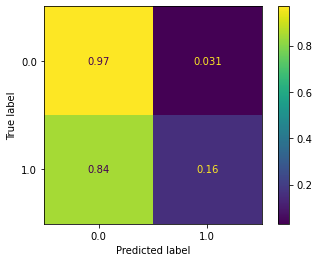

Prediction Accuracy:  0.9513170146594357
F1:  0.12228014368824006
Precision:  0.10004156029210948
Recall:  0.1572317262830482



In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from numpy import ravel

eff_abc = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    abc = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced", n_estimators=12, n_jobs=-1), n_estimators=5, random_state=42).fit(x_train, y_train_ravel)
    pred = abc.predict(x_test)
    print(f"AdaBoost ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_abc.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model AdaBoost dobrze poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane 16% próbek dodatnich oraz 97% próbek ujemnych. Mimo niższej skuteczności przewidywania klasy dodatniej, na podstawie wyniku F1 score można stwierdzić, że model AdaBoost dla danych min-max najlepiej poradził sobie z zadaniem klasyfikacji.

#### ENSEBLE - VOTING CLASSIFIER

Voting (standarized data):


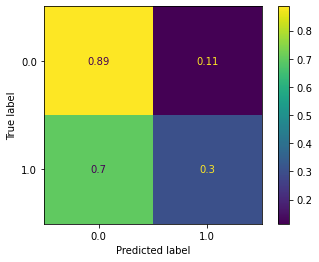

Prediction Accuracy:  0.8732427058372086
F1:  0.09356500714785995
Precision:  0.05531354932389509
Recall:  0.3033281493001555

Voting (min-max data):


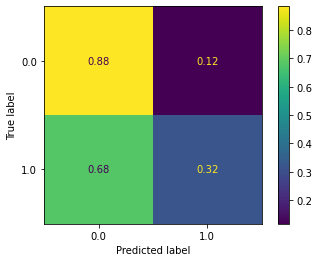

Prediction Accuracy:  0.8708075167511492
F1:  0.09592796717586638
Precision:  0.0564899593064402
Recall:  0.31779160186625194



In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from numpy import ravel

eff_vtc = []

for name, x_train, y_train, x_test, y_test in data_sets:
    y_train_ravel=ravel(y_train)
    vtc = VotingClassifier(estimators=[('nb', GaussianNB()),
                                    ('rfc', RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced", n_estimators=12, n_jobs=-1)),
                                    ('xgb', XGBClassifier(tree_method='gpu_hist', scale_pos_weight=49))], voting='hard').fit(x_train, y_train_ravel)
    pred = vtc.predict(x_test)
    print(f"Voting ({name} data):")
    ConfusionMatrixDisplay.from_predictions(y_test,pred, normalize='true')
    plt.show()
    eff_vtc.append(effectiveness_measures_classifier(y_test, pred))
    print("")

Na powyższych macierzch pomyłek można zauważyć, że model Voting Classifier bardzo dobrze poradził sobie z klasyfikacją odwołanych lotów. Poprawnie zostało zaklasyfikowane 32% próbek dodatnich oraz 88% próbek ujemnych. Pomimo wyższej od poprzednich modeli skuteczności przewidywania lotów odwołanych ze względu na niższą czułość na loty nieodwołane wynik F1 score jest niższy niż dla modeli AdaBoost i XGBoost.

## WYNIKI

In [15]:
from prettytable import PrettyTable


def add_results(table, normalization_type, model, results):
    (acc, f1, prec, recall)= results
    table.add_row([normalization_type, model, round(acc, 5), round(f1, 5), round(prec, 5), round(recall, 5)])

def create_summary():
    summaryTable = PrettyTable(['normalization type', 'model', 'Accuracy', 'F1', 'Precision', 'Recall'])
    add_results(summaryTable, "standard", "Decision Tree Classifier", eff_dtc[0])
    add_results(summaryTable, "min-max", "Decision Tree Classifier", eff_dtc[1])
    add_results(summaryTable, "standard", "Gaussian Naive Bayes", eff_gnb[0])
    add_results(summaryTable, "min-max", "Gaussian Naive Bayes", eff_gnb[1])
    add_results(summaryTable, "standard", "Logistic Regression", eff_lr[0])
    add_results(summaryTable, "min-max", "Logistic Regression", eff_lr[1])
    add_results(summaryTable, "standard", "Random Forest Classifier", eff_rfc[0])
    add_results(summaryTable, "min-max", "Random Forest Classifier", eff_rfc[1])
    add_results(summaryTable, "standard", "XGBoost Classifier", eff_xgb[0])
    add_results(summaryTable, "min-max", "XGBoost Classifier", eff_xgb[1])
    add_results(summaryTable, "standard", "AdaBoost Classifier", eff_abc[0])
    add_results(summaryTable, "min-max", "AdaBoost Classifier", eff_abc[1])
    add_results(summaryTable, "standard", "Voting Classifier", eff_vtc[0])
    add_results(summaryTable, "min-max", "Voting Classifier", eff_vtc[1])
    print(summaryTable)


In [16]:
create_summary()

+--------------------+--------------------------+----------+---------+-----------+---------+
| normalization type |          model           | Accuracy |    F1   | Precision |  Recall |
+--------------------+--------------------------+----------+---------+-----------+---------+
|      standard      | Decision Tree Classifier |  0.8354  | 0.07157 |  0.04074  | 0.29415 |
|      min-max       | Decision Tree Classifier | 0.82985  | 0.07083 |  0.04014  | 0.30068 |
|      standard      |   Gaussian Naive Bayes   | 0.29958  | 0.05801 |  0.02987  | 0.99994 |
|      min-max       |   Gaussian Naive Bayes   | 0.30754  | 0.05864 |   0.0302  | 0.99994 |
|      standard      |   Logistic Regression    | 0.90659  | 0.04673 |  0.02996  | 0.10616 |
|      min-max       |   Logistic Regression    | 0.95166  | 0.03262 |   0.0287  | 0.03779 |
|      standard      | Random Forest Classifier |  0.8992  | 0.08331 |  0.05182  | 0.21238 |
|      min-max       | Random Forest Classifier | 0.89504  | 0.08939 |

### STRATIFIED CROSS VALIDATION

In [17]:
def cross_validation_split(dataInput):
    cancelled = dataInput['Cancelled']==1
    dataCancelled = dataInput[cancelled]
    dataNotCancelled = dataInput[~cancelled]
    DF_x = pd.DataFrame(dataCancelled[:], columns = columns)
    DF_y = pd.DataFrame(dataNotCancelled[:], columns = columns)
    finalDF = DF_x.append(DF_y)
    finalDF = finalDF.sample(frac=1, random_state=42)
    finalDF = finalDF.to_numpy()
    return finalDF[:, :-1], finalDF[:, -1:]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
def mp(test, predicted):
    tn=0
    tp=0
    fn=0
    fp=0
    for i in range(len(test)):
        if test[i] == predicted[i]:
            if test[i] == 0:
                tn += 1
            else:
                tp += 1
        else:
            if test[i] == 0:
                fn += 1
            else:
                fp += 1
    return tp, tn, fn, fp

def f1(tp, tn, fn, fp):
    return 2*(2*tp/(2*tp+fp+fn))/2

In [21]:
def cross_validation(df, k, classifier, **kwargs):
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    sum_f1_score = 0
    mod = len(df) % k
    if(mod != 0):
        df.drop(df.tail(mod).index,inplace=True)
    n = int(len(df) / k)
    resultSum = 0
    for i in range(k):
        test = df[i*n:(i+1)*n + 1]
        x_test, y_test = cross_validation_split(test)
        train = pd.concat([df[:i * n], df[(i+1) * n + 1:]])
        x_train, y_train = cross_validation_split(train)
        c = classifier(**kwargs)
        if not isinstance(c, DecisionTreeClassifier):
            y_train= ravel(y_train)
        c.fit(x_train,y_train)
        predictions = c.predict(x_test)
        sum_f1_score += f1_score(y_test, predictions)
        tp1, tn1, fn1, fp1 = mp(y_test, predictions)
        tp += tp1
        tn += tn1
        fn += fn1
        fp += fp1
    print("Classification F1 - own implementation: " +  str(f1(tp, tn, fn, fp)))
    print("Classification F1 - build function: " +  str(sum_f1_score/k))
    return round(sum_f1_score/k, 5)

In [22]:
from sklearn import preprocessing


def create_summary_cross_validation(n):
    summaryTable = PrettyTable(['scaler', 'model', 'K folds', 'cross validation f1-score'])
    summaryTable.add_row(["standard", "Decision Tree Classifier", n,  cross_validation(data_standard, n, DecisionTreeClassifier, max_depth=10, class_weight="balanced")])
    summaryTable.add_row(["min-max", "Decision Tree Classifier", n,  cross_validation(data_minmax, n, DecisionTreeClassifier, max_depth=10, class_weight="balanced")])
    summaryTable.add_row(["standard", "Gaussian Naive Bayes", n, cross_validation(data_standard, n,  GaussianNB)])
    summaryTable.add_row(["min-max", "Gaussian Naive Bayes", n, cross_validation(data_minmax, n,  GaussianNB)])
    print(summaryTable)

In [23]:
create_summary_cross_validation(5)

Classification F1 - own implementation: 0.07602574876910148
Classification F1 - build function: 0.07878909155950017
Classification F1 - own implementation: 0.07667480402763804
Classification F1 - build function: 0.0752072099852612
Classification F1 - own implementation: 0.05877414183546071
Classification F1 - build function: 0.059054887292804094
Classification F1 - own implementation: 0.05932013773656266
Classification F1 - build function: 0.05959630228368264
+----------+--------------------------+---------+---------------------------+
|  scaler  |          model           | K folds | cross validation f1-score |
+----------+--------------------------+---------+---------------------------+
| standard | Decision Tree Classifier |    5    |          0.07879          |
| min-max  | Decision Tree Classifier |    5    |          0.07521          |
| standard |   Gaussian Naive Bayes   |    5    |          0.05905          |
| min-max  |   Gaussian Naive Bayes   |    5    |           0.0596  

### ETAP 3 - OPTYMALIZACJA CECH

#### Wynik odniesienia - algorytm XGBoost

Ze względy na dużą ilość rekordów w oryginalnym zbiorze - ok. 7,4 mln - próby optymalizacji algorytmu na całym zbiorze nie powiodły się - program wyłączał się ze względu na zbyt duże użycie procesora i pamięci RAM. Z tego powodu zbiór został ograniczony do około 320 tysięcy rekordów w taki sposób, że wzięte zostały wszystkie rekordy z klasy dodatniej (czyli odwołanych lotów) oraz losowo wybrane rekordy z klasy ujemnej (czyli nieodwołanych lotów). W ten sposób zbiór został zrównoważony i zawierał około 160 tysięcy rekordów z klasy dodatniej i 160 tysięcy rekordów z klasy ujemnej.

In [9]:
from sklearn.utils import shuffle

def balance_data(data):
    cancelled = data['Cancelled'] == 1
    data_cancelled = data[cancelled]
    data_not_cancelled = data[~cancelled]
    data_not_cancelled = data_not_cancelled.sample(n=len(data_cancelled), random_state=42)
    data = pd.concat([data_cancelled, data_not_cancelled])
    data = shuffle(data, random_state=42)
    return data

In [13]:
from sklearn.model_selection import train_test_split

balanced_data = balance_data(data_standard)

balanced_data.drop(['Year'], axis=1, inplace=True)
X = balanced_data.drop(['Cancelled'], axis=1)
y = balanced_data['Cancelled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

XGBoost Classifier - base score:


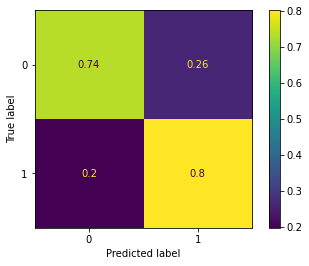

Prediction Accuracy:  0.7692068429237947
F1:  0.7765464072757935
Precision:  0.752612223454556
Recall:  0.8020528771384137



In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

eff_xgb = []
xgb = XGBClassifier(tree_method='gpu_hist').fit(X_train, y_train)
pred = xgb.predict(X_test)
print(f"XGBoost Classifier - base score:")
ConfusionMatrixDisplay.from_predictions(y_test, pred, normalize='true')
plt.show()
eff_xgb.append(effectiveness_measures_classifier(y_test, pred))
print("")

Jako wynik odniesienia przyjmujemy wynik F1 score dla algorytmu XGBoost na zbiorze danych zrównoważonym.

#### Optymalizacja cech metodą GridSearch

In [23]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [1, 5, 10, 15],
    'n_estimators': [50, 75, 100, 125, 150],
    'min_child_weight': [1, 5, 10]
}

xgb = XGBClassifier(tree_method='gpu_hist')
grid = GridSearchCV(xgb, params, cv=2, scoring='f1', n_jobs=-1, verbose=4)
grid.fit(X_train, y_train)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [25]:
print(f"XGBoost Classifier (GridSearchCV) - best score: {grid.best_score_}")
print(f"XGBoost Classifier (GridSearchCV) - best params: {grid.best_params_}")

pred = grid.predict(X_test)
print(f"XGBoost Classifier (GridSearchCV) - best score on test set: {f1_score(y_test, pred)}")

XGBoost Classifier (GridSearchCV) - best score: 0.7801559184286166
XGBoost Classifier (GridSearchCV) - best params: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 150}
XGBoost Classifier (GridSearchCV) - best score on test set: 0.7860370364697412


#### Optymalizacja cech za pomocą Optuny

In [32]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    min_split_loss = trial.suggest_uniform('min_split_loss', 0.01, 1)
    max_delta_step = trial.suggest_int('max_delta_step', 1, 10)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.01, 1)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.01, 1)
    xgb = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight, min_split_loss=min_split_loss, max_delta_step=max_delta_step, reg_lambda=reg_lambda, reg_alpha=reg_alpha, tree_method='gpu_hist')
    xgb.fit(X_train, y_train)
    pred = xgb.predict(X_test)
    return f1_score(y_test, pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2022-12-18 23:50:48,310] A new study created in memory with name: no-name-e8824439-f2e7-4156-ad36-0fb65a3d9116
[I 2022-12-18 23:50:48,762] Trial 0 finished with value: 0.7783327279331638 and parameters: {'learning_rate': 0.4182500284591305, 'max_depth': 6, 'n_estimators': 107, 'min_child_weight': 8, 'min_split_loss': 0.9186537534259472, 'max_delta_step': 3, 'reg_lambda': 0.24615113570692618, 'reg_alpha': 0.7472725553266728}. Best is trial 0 with value: 0.7783327279331638.
[I 2022-12-18 23:50:49,102] Trial 1 finished with value: 0.771882168296511 and parameters: {'learning_rate': 0.9933821455175506, 'max_depth': 4, 'n_estimators': 78, 'min_child_weight': 2, 'min_split_loss': 0.42414459830754175, 'max_delta_step': 3, 'reg_lambda': 0.9486475630100699, 'reg_alpha': 0.9931267051035182}. Best is trial 0 with value: 0.7783327279331638.
[I 2022-12-18 23:50:50,262] Trial 2 finished with value: 0.7826419481155164 and parameters: {'learning_rate': 0.38817846019108915, 'max_depth': 13, 'n_estim

In [33]:
print(f"XGBoost Classifier (Optuna) - best score: {study.best_value}")
print(f"XGBoost Classifier (Optuna) - best params: {study.best_params}")

XGBoost Classifier (Optuna) - best score: 0.7887531237064406
XGBoost Classifier (Optuna) - best params: {'learning_rate': 0.08907221851001633, 'max_depth': 17, 'n_estimators': 200, 'min_child_weight': 4, 'min_split_loss': 0.06622793142425584, 'max_delta_step': 10, 'reg_lambda': 0.22359322421155797, 'reg_alpha': 0.570744063994978}


#### Genetyczna optymalizacja cech - PySwarm

In [38]:
import pyswarm as ps
from sklearn.metrics import f1_score

def f(x):
        learning_rate = x[0]
        max_depth = int(x[1])
        n_estimators = int(x[2])
        min_child_weight = int(x[3])
        min_split_loss = x[4]
        max_delta_step = int(x[5])
        reg_lambda = x[6]
        reg_alpha = x[7]

        xgb = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight, min_split_loss=min_split_loss, max_delta_step=max_delta_step, reg_lambda=reg_lambda, reg_alpha=reg_alpha, tree_method='gpu_hist')
        xgb.fit(X_train, y_train)
        pred = xgb.predict(X_test)
        return -f1_score(y_test, pred)

def find_best_parameters():
    lb = [0.01, 1, 50, 1, 0.01, 1, 0.01, 0.01]
    ub = [1, 20, 200, 10, 1, 10, 1, 1]
    xopt, fopt = ps.pso(f, lb, ub, swarmsize=40, maxiter=40, debug=True)
    print(xopt, fopt)
    return xopt, fopt

In [39]:
xopt, fopt = find_best_parameters()

No constraints given.
Best after iteration 1: [  0.2162357   12.61702212 129.56103857   4.54250395   0.17402518
   7.33417724   0.2157176    0.94353487] -0.7866368756121449
Best after iteration 2: [  0.2162357   12.61702212 129.56103857   4.54250395   0.17402518
   7.33417724   0.2157176    0.94353487] -0.7866368756121449
Best after iteration 3: [  0.2162357   12.61702212 129.56103857   4.54250395   0.17402518
   7.33417724   0.2157176    0.94353487] -0.7866368756121449
New best for swarm at iteration 4: [  0.18308861  14.13771108 112.65086083   4.4961677    0.16067666
   6.42302895   0.22924376   0.92235321] -0.7871727267153105
New best for swarm at iteration 4: [2.11707382e-01 1.38455919e+01 1.16345177e+02 2.30893103e+00
 7.89834327e-02 6.86406151e+00 3.26317192e-01 9.18302076e-01] -0.7879825178031113
Best after iteration 4: [2.11707382e-01 1.38455919e+01 1.16345177e+02 2.30893103e+00
 7.89834327e-02 6.86406151e+00 3.26317192e-01 9.18302076e-01] -0.7879825178031113
Best after iterati

Algorytm uruchomiony ponownie jako samodzielny skrypt pythona, ponieważ w notebooku nie działał poprawnie - zakończył działanie przed osiągnięciem 40 iteracji.

#### Wynik algorytmu genetycznego PSO - 100 osobników, 100 iteracji (poniżej zapis z działania algorytmu)

In [ ]:
"""
No constraints given.
New best for swarm at iteration 1: [1.84859443e-01 1.63735736e+01 1.04235495e+02 1.00000000e+01
 1.00000000e-02 5.20033438e+00 1.00000000e-02 7.90345869e-01] -0.7852378835037794
New best for swarm at iteration 1: [1.49332201e-01 1.15783302e+01 1.94470675e+02 9.92633489e+00
 1.00000000e-02 1.00000000e+00 5.63353895e-01 2.56253254e-01] -0.7854273275796229
Best after iteration 1: [1.49332201e-01 1.15783302e+01 1.94470675e+02 9.92633489e+00
 1.00000000e-02 1.00000000e+00 5.63353895e-01 2.56253254e-01] -0.7854273275796229
New best for swarm at iteration 2: [8.50570070e-02 1.44799437e+01 1.62378816e+02 1.00000000e+00
 2.80734681e-01 6.98385300e+00 6.95426453e-01 1.27180564e-01] -0.7860798362333673
New best for swarm at iteration 2: [2.16944127e-01 9.10069595e+00 2.00000000e+02 5.84724220e+00
 1.00000000e-02 7.60821470e+00 8.33975570e-01 1.52948830e-01] -0.7864606373079915
Best after iteration 2: [2.16944127e-01 9.10069595e+00 2.00000000e+02 5.84724220e+00
 1.00000000e-02 7.60821470e+00 8.33975570e-01 1.52948830e-01] -0.7864606373079915
New best for swarm at iteration 3: [2.13749759e-01 1.68271121e+01 1.27233498e+02 8.75468617e+00
 3.94132684e-02 5.69487069e+00 3.31279316e-01 5.79310474e-01] -0.7864878961740251
New best for swarm at iteration 3: [1.10459905e-01 1.35781046e+01 1.90660153e+02 8.91799821e+00
 1.00000000e-02 1.42753995e+00 5.78186266e-01 1.00000000e-02] -0.7867376928728875
New best for swarm at iteration 3: [1.51004387e-01 1.32146792e+01 1.50803238e+02 2.19634517e+00
 1.54204199e-02 3.36793015e+00 1.74526794e-01 3.97452162e-01] -0.7883155833027299
Best after iteration 3: [1.51004387e-01 1.32146792e+01 1.50803238e+02 2.19634517e+00
 1.54204199e-02 3.36793015e+00 1.74526794e-01 3.97452162e-01] -0.7883155833027299
Best after iteration 4: [1.51004387e-01 1.32146792e+01 1.50803238e+02 2.19634517e+00
 1.54204199e-02 3.36793015e+00 1.74526794e-01 3.97452162e-01] -0.7883155833027299
New best for swarm at iteration 5: [1.08942456e-01 1.76729502e+01 1.79654874e+02 4.53804322e+00
 1.00000000e-02 2.34149821e+00 3.14756399e-01 1.57854451e-01] -0.7883647269444403
Best after iteration 5: [1.08942456e-01 1.76729502e+01 1.79654874e+02 4.53804322e+00
 1.00000000e-02 2.34149821e+00 3.14756399e-01 1.57854451e-01] -0.7883647269444403
New best for swarm at iteration 6: [1.66904456e-01 1.33011647e+01 1.63904254e+02 6.90789938e+00
 1.00000000e-02 3.42004149e+00 4.21109571e-01 3.51472973e-01] -0.7884156416375988
Best after iteration 6: [1.66904456e-01 1.33011647e+01 1.63904254e+02 6.90789938e+00
 1.00000000e-02 3.42004149e+00 4.21109571e-01 3.51472973e-01] -0.7884156416375988
New best for swarm at iteration 7: [1.44807143e-01 1.57496278e+01 1.64648926e+02 4.23729048e+00
 1.00000000e-02 3.75036416e+00 3.04687561e-01 3.33604765e-01] -0.788460065268351
New best for swarm at iteration 7: [1.19758569e-01 1.59774839e+01 1.69250027e+02 4.08761911e+00
 1.00000000e-02 2.95784403e+00 1.18726208e-01 3.12760928e-01] -0.7886680864755542
Best after iteration 7: [1.19758569e-01 1.59774839e+01 1.69250027e+02 4.08761911e+00
 1.00000000e-02 2.95784403e+00 1.18726208e-01 3.12760928e-01] -0.7886680864755542
New best for swarm at iteration 8: [1.29575705e-01 1.52216982e+01 1.70359268e+02 4.81397610e+00
 1.00000000e-02 4.34093842e+00 3.07272396e-01 3.40580357e-01] -0.7888482772331737
New best for swarm at iteration 8: [1.04240829e-01 1.53918173e+01 1.49529144e+02 4.40746650e+00
 1.00000000e-02 3.45165612e+00 3.52907483e-01 3.01550249e-01] -0.788969778539092
Best after iteration 8: [1.04240829e-01 1.53918173e+01 1.49529144e+02 4.40746650e+00
 1.00000000e-02 3.45165612e+00 3.52907483e-01 3.01550249e-01] -0.788969778539092
New best for swarm at iteration 9: [1.01049074e-01 1.67784272e+01 1.69743175e+02 4.65785786e+00
 1.00000000e-02 2.49971731e+00 2.13464765e-01 3.05634325e-01] -0.7889958818756602
Best after iteration 9: [1.01049074e-01 1.67784272e+01 1.69743175e+02 4.65785786e+00
 1.00000000e-02 2.49971731e+00 2.13464765e-01 3.05634325e-01] -0.7889958818756602
Best after iteration 10: [1.01049074e-01 1.67784272e+01 1.69743175e+02 4.65785786e+00
 1.00000000e-02 2.49971731e+00 2.13464765e-01 3.05634325e-01] -0.7889958818756602
New best for swarm at iteration 11: [1.18450624e-01 1.62700988e+01 1.65724104e+02 4.43380273e+00
 1.00000000e-02 3.16687283e+00 2.23656374e-01 3.05092542e-01] -0.7890602269421008
Best after iteration 11: [1.18450624e-01 1.62700988e+01 1.65724104e+02 4.43380273e+00
 1.00000000e-02 3.16687283e+00 2.23656374e-01 3.05092542e-01] -0.7890602269421008
New best for swarm at iteration 12: [1.09933205e-01 1.59777653e+01 1.66308893e+02 4.14378709e+00
 1.00000000e-02 3.73051784e+00 2.74835539e-01 2.84985098e-01] -0.7892093820809604
Best after iteration 12: [1.09933205e-01 1.59777653e+01 1.66308893e+02 4.14378709e+00
 1.00000000e-02 3.73051784e+00 2.74835539e-01 2.84985098e-01] -0.7892093820809604
New best for swarm at iteration 13: [1.08854344e-01 1.59424278e+01 1.65285414e+02 4.21678051e+00
 1.31643863e-02 3.73098097e+00 2.61719354e-01 2.93663223e-01] -0.7892410966863922
Best after iteration 13: [1.08854344e-01 1.59424278e+01 1.65285414e+02 4.21678051e+00
 1.31643863e-02 3.73098097e+00 2.61719354e-01 2.93663223e-01] -0.7892410966863922
New best for swarm at iteration 14: [1.10733858e-01 1.69994203e+01 1.68272182e+02 4.11619656e+00
 1.13772997e-02 3.57915242e+00 2.80339017e-01 2.94910187e-01] -0.7894019032440964
Best after iteration 14: [1.10733858e-01 1.69994203e+01 1.68272182e+02 4.11619656e+00
 1.13772997e-02 3.57915242e+00 2.80339017e-01 2.94910187e-01] -0.7894019032440964
New best for swarm at iteration 15: [1.17441394e-01 1.66650390e+01 1.68478444e+02 4.20861847e+00
 1.00000000e-02 3.36208502e+00 2.59486505e-01 3.01919416e-01] -0.789488192593954
Best after iteration 15: [1.17441394e-01 1.66650390e+01 1.68478444e+02 4.20861847e+00
 1.00000000e-02 3.36208502e+00 2.59486505e-01 3.01919416e-01] -0.789488192593954
Best after iteration 16: [1.17441394e-01 1.66650390e+01 1.68478444e+02 4.20861847e+00
 1.00000000e-02 3.36208502e+00 2.59486505e-01 3.01919416e-01] -0.789488192593954
New best for swarm at iteration 17: [1.22929986e-01 1.64234136e+01 1.69494154e+02 4.37547621e+00
 2.17964690e-02 3.26767506e+00 2.46344899e-01 3.05963913e-01] -0.7894978848629759
Best after iteration 17: [1.22929986e-01 1.64234136e+01 1.69494154e+02 4.37547621e+00
 2.17964690e-02 3.26767506e+00 2.46344899e-01 3.05963913e-01] -0.7894978848629759
Best after iteration 18: [1.22929986e-01 1.64234136e+01 1.69494154e+02 4.37547621e+00
 2.17964690e-02 3.26767506e+00 2.46344899e-01 3.05963913e-01] -0.7894978848629759
New best for swarm at iteration 19: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 19: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 20: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 21: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 22: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 23: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 24: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 25: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 26: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 27: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 28: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 29: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 30: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 31: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 32: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 33: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 34: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 35: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 36: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 37: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 38: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 39: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 40: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 41: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 42: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 43: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 44: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 45: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 46: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 47: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 48: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 49: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 50: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 51: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 52: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 53: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 54: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 55: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 56: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 57: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 58: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 59: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
Best after iteration 60: [1.19818506e-01 1.63847304e+01 1.68809708e+02 4.33691044e+00
 1.67618558e-02 3.34314708e+00 2.63727840e-01 3.04278488e-01] -0.789660772837312
New best for swarm at iteration 61: [1.23060443e-01 1.61721638e+01 1.67550551e+02 4.38319301e+00
 1.42779816e-02 3.22728508e+00 2.65883996e-01 3.01022956e-01] -0.7897732488754247
Best after iteration 61: [1.23060443e-01 1.61721638e+01 1.67550551e+02 4.38319301e+00
 1.42779816e-02 3.22728508e+00 2.65883996e-01 3.01022956e-01] -0.7897732488754247
Best after iteration 62: [1.23060443e-01 1.61721638e+01 1.67550551e+02 4.38319301e+00
 1.42779816e-02 3.22728508e+00 2.65883996e-01 3.01022956e-01] -0.7897732488754247
Best after iteration 63: [1.23060443e-01 1.61721638e+01 1.67550551e+02 4.38319301e+00
 1.42779816e-02 3.22728508e+00 2.65883996e-01 3.01022956e-01] -0.7897732488754247
Best after iteration 64: [1.23060443e-01 1.61721638e+01 1.67550551e+02 4.38319301e+00
 1.42779816e-02 3.22728508e+00 2.65883996e-01 3.01022956e-01] -0.7897732488754247
Best after iteration 65: [1.23060443e-01 1.61721638e+01 1.67550551e+02 4.38319301e+00
 1.42779816e-02 3.22728508e+00 2.65883996e-01 3.01022956e-01] -0.7897732488754247
New best for swarm at iteration 66: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 66: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 67: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 68: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 69: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 70: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 71: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
Best after iteration 72: [1.21771214e-01 1.58554228e+01 1.70031772e+02 4.29559179e+00
 1.68794283e-02 3.02374791e+00 2.60124823e-01 3.14125584e-01] -0.7897985754767557
New best for swarm at iteration 73: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 73: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 74: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 75: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 76: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 77: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 78: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 79: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 80: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 81: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 82: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
Best after iteration 83: [1.21086791e-01 1.58763382e+01 1.69356153e+02 4.38002527e+00
 1.51022025e-02 3.15619592e+00 2.62185763e-01 3.10350453e-01] -0.7899350251317886
New best for swarm at iteration 84: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 84: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 85: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 86: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 87: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 88: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 89: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 90: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 91: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 92: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 93: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 94: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 95: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 96: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 97: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 98: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 99: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Best after iteration 100: [1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
Stopping search: maximum iterations reached --> 100
[1.21973987e-01 1.59727333e+01 1.68619573e+02 4.41940904e+00
 1.41973285e-02 3.23333669e+00 2.65547617e-01 3.15130029e-01] -0.7900871509748963
"""

#### Podsumowanie optymalizacji cech

In [15]:
from prettytable import PrettyTable

summaryTable = PrettyTable(['metoda', 'F-score', 'Learning rate', 'Max depth', 'N estimators', 'Min child weight', 'Min split loss', 'Min deta step', 'Reg lambda', 'Reg alpha'])
summaryTable.add_row(['PSO', 0.79009, 0.12197, 15, 168, 4, 0.0141973, 3, 0.26555, 0.31513])
summaryTable.add_row(['Optuna', 0.78875, 0.089072, 17, 200,  4, 0.06622793, 10, 0.223593, 0.570744])
summaryTable.add_row(['GridSearchCV',  0.78604, 0.1, 15, 150, 10, '-', '-', '-', '-'])
summaryTable.add_row(['Bez optymalizacji', 0.7765, '-', '-', '-', '-', '-', '-', '-', '-'])


In [16]:
summaryTable

metoda,F-score,Learning rate,Max depth,N estimators,Min child weight,Min split loss,Min deta step,Reg lambda,Reg alpha
PSO,0.79009,0.12197,15,168,4,0.0141973,3,0.26555,0.31513
Optuna,0.78875,0.089072,17,200,4,0.06622793,10,0.223593,0.570744
GridSearchCV,0.78604,0.1,15,150,10,-,-,-,-
Bez optymalizacji,0.7765,-,-,-,-,-,-,-,-


Na postawie otrzymanych rezultatów można stwierdzić, że najlepszy wynik F1 score osiągnięto dla algorytmu XGBoost zoptymalizowanym za pomocą algorytmu genetycznego. Wynik ten jest lepszy niż wynik odniesienia dla algorytmu XGBoost o około 0,015. Wynik osiągnięty za pomocą Optuny i GridSeachCV nie jest jednak dużo słabszy niż ten osiągnięty za pomocą algorytmu genetycznego.